# 04 UTA_Electric_Active Energy (kWh)

In [1]:
import pandas as pd

In [2]:
cd ..

c:\Users\Usuario\OneDrive\Documents\IE\3. Trimestre\Venture Lab & Capstone\Capstone\Tech side\vl_optimizer


## Definition of the constrain equation

This formula allows you to manage the UTA’s energy consumption by adjusting settings while considering operational and material constraints, ensuring optimal energy management without affecting the testing output quality.

**UTA_Electric_Active Energy = a⋅operational_presence + b⋅fabric_in_chamber + c⋅testing_schedule + d⋅workload + e⋅standby_power_down**

- **UTA_Electric_Active Energy** = Energy consumption of the Ultrasonic Testing Apparatus in a given period.

- **operational_presence** = Operational Presence: Indicates if the UTA is actively in operation - Given.

- **fabric_in_chamber** = Fabric in Chamber: Whether there is fabric loaded in the testing chamber, suggesting the UTA is about to be used - Given.

- **testing_schedule** = Testing Schedule: Reflects planned testing times which predict active use - Given.

- **workload** = Workload: Measures the queue of testing tasks assigned to the UTA - Given.

- **standby_power_down** = Standby Power Down: Managing power usage when the UTA is not actively testing - Controllable.

- **a,b,c,d,e** = Coefficients for each factor.

In [3]:
df = pd.read_csv('data/processed_data/industrial_sites_processed/2024-07-06T21-45-14_industrial_site2_processed.csv')

In [4]:
df.columns

Index(['Time', '02 Production_Electric_Active Energy (kWh)',
       '02 Production_Electric_Active Power (kW)',
       '02 Production_Electric_Apparent Power (kVa)',
       '02 Production_Electric_Power Factor (real)',
       '03 Chiller Group_Electric_Active Energy (kWh)',
       '03 Chiller Group_Electric_Active Power (kW)',
       '03 Chiller Group_Electric_Apparent Power (kVa)',
       '03 Chiller Group_Electric_Power Factor (real)',
       '04 UTA_Electric_Active Energy (kWh)',
       '04 UTA_Electric_Active Power (kW)',
       '04 UTA_Electric_Apparent Power (kVa)',
       '04 UTA_Electric_Power Factor (real)',
       '05 Compressors_Electric_Active Energy (kWh)',
       '05 Compressors_Electric_Active Power (kW)',
       '05 Compressors_Electric_Apparent Power (kVa)',
       '05 Compressors_Electric_Power Factor (real)',
       '06 Offices_Electric_Active Energy (kWh)',
       '06 Offices_Electric_Active Power (kW)',
       '06 Offices_Electric_Apparent Power (kVa)',
       '06 

In [5]:
UTA_target = (df['04 UTA_Electric_Active Energy (kWh)']).dropna()
UTA_target.to_csv('data/target_variables/target_UTA.csv', index=False)

## Other factors to include in the constrain equation

To effectively simulate data for the UTA (Ultrasonic Testing Apparatus) based on the equation, we first need to establish logical boundaries for each variable. These boundaries should reflect realistic operational scenarios and constraints. Here’s a suggested framework:

### 1. **operational_presence**
   - **Type:** Binary (0 or 1)
   - **Minimum:** 0 (UTA is not in operation)
   - **Maximum:** 1 (UTA is actively in operation)

### 2. **fabric_in_chamber**
   - **Type:** Binary (0 or 1)
   - **Minimum:** 0 (No fabric loaded in the chamber)
   - **Maximum:** 1 (Fabric is loaded, indicating readiness or impending use)

### 3. **testing_schedule**
   - **Type:** Continuous or Categorical (e.g., hours of operation)
   - **Minimum:** 0 (No scheduled tests)
   - **Maximum:** 24 (Reflects the maximum hours in a day that testing can be scheduled, if using hours as the measure)

### 4. **workload**
   - **Type:** Continuous
   - **Minimum:** 0 (No tests queued)
   - **Maximum:** 100 (Maximum number of tests that can be queued based on operational capacity)

### 5. **standby_power_down**
   - **Type:** Binary or Continuous (0 to 1 scale if continuous, reflecting degree of power reduction)
   - **Minimum:** 0 (Full power consumption, no power-saving measures in place)
   - **Maximum:** 1 (Fully powered down to the lowest safe operational level)

For **workload**, which should scale with energy consumption, we could set dynamic maximums based on the percentiles of energy consumption:

- Use the 75th percentile as a typical upper limit during high use times.
- Scale the maximum values of these variables proportionally to how close the energy consumption is to the maximum observed value.

Here are some key statistics from the total energy consumption data:

In [6]:
# Calculating statistical details for the total energy consumption data
UTA_stats = df['04 UTA_Electric_Active Energy (kWh)'].describe()
UTA_stats

count    8760.000000
mean       20.799763
std        16.644627
min         0.000000
25%         1.440000
50%        21.425000
75%        35.600000
max        55.275000
Name: 04 UTA_Electric_Active Energy (kWh), dtype: float64

## Synthesized dataset

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

# Number of samples is equal to the number of entries in the consumption data
n_samples = len(UTA_target)

# Initialize the random seed for reproducibility
np.random.seed(42)

# Define dynamic ranges based on energy consumption percentiles
max_energy = df['04 UTA_Electric_Active Energy (kWh)'].max()
scale_factor = df['04 UTA_Electric_Active Energy (kWh)'] / max_energy


# Define a controlled noise level relative to the scale of each feature
noise_level = 0.15  # Noise level as a percentage of feature's max value

# Generate base data with a systematic approach to workload
data = {
    'operational_presence': np.random.binomial(1, p=0.2 + 0.6 * scale_factor),
    'fabric_in_chamber': np.random.binomial(1, p=0.1 + 0.8 * scale_factor), 
    'testing_schedule': np.maximum(0, 24 * scale_factor + np.random.normal(0, 24 * noise_level, n_samples)),
    'workload': np.maximum(0, 10 * scale_factor + np.random.normal(0, 10 * noise_level, n_samples)),
    'standby_power_down': np.random.choice([0, 1], size=n_samples, p=[0.8, 0.2])
}

df_simulated = pd.DataFrame(data)

# Save the generated data to a new CSV
output_path = 'data/synthesized_data/UTA_synthesized.csv'
df_simulated.to_csv(output_path, index=False)

output_path

'data/synthesized_data/UTA_synthesized.csv'

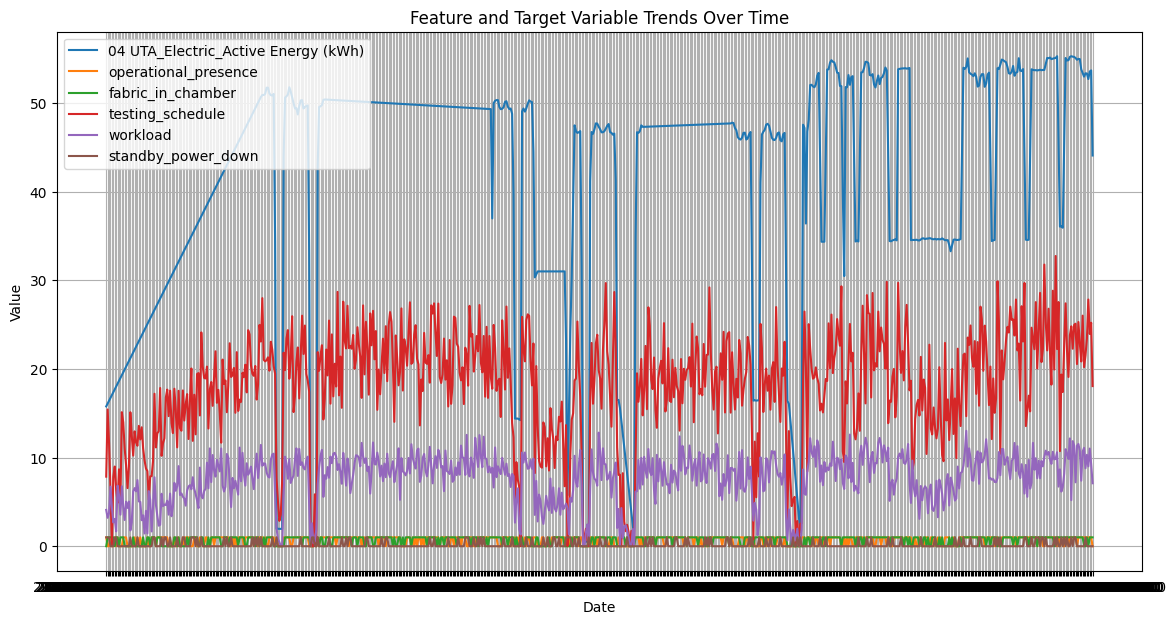

In [8]:
import matplotlib.pyplot as plt

# Combine target and features into one DataFrame
df_combined = pd.concat([df['Time'], df['04 UTA_Electric_Active Energy (kWh)'], df_simulated], axis=1)
df_combined.set_index('Time', inplace=True)

# Define the time period you want to plot
start_date = '2023-06-01'
end_date = '2023-06-30'

# Slice the DataFrame to the desired period
df_period = df_combined.loc[start_date:end_date]

# Plotting
plt.figure(figsize=(14, 7))
for column in df_period.columns:
    plt.plot(df_period.index, df_period[column], label=column)
plt.legend()
plt.title('Feature and Target Variable Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

## Get cofficients

In [9]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from joblib import dump

# Define the target
target = UTA_target

# Define the features
features = df_simulated.columns

# Split the data into features (X) and target (y)
X = df_simulated
y = target

# Initialize the linear regression model
model = LinearRegression()

# Perform k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results_mse = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
cv_results_r2 = cross_val_score(model, X, y, cv=kfold, scoring='r2')

# Fit the model on the entire dataset
model.fit(X, y)

# Get the intercept and coefficients
intercept = model.intercept_
coefficients = model.coef_

# Save the trained model to a file
model_params = {
    'intercept': intercept,
    'coefficients': coefficients,
    'features': features
}
model_filename = 'equation_modeling/models/UTA_consumption_model.joblib'
dump(model_params, model_filename)

# Calculate and print performance metrics
y_pred = model.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f'Mean Squared Error (Cross-Validation): {-cv_results_mse.mean()}')
print(f'Standard Deviation (Cross-Validation): {cv_results_mse.std()}')
print(f'R^2 Score (Cross-Validation): {cv_results_r2.mean()}')
print(f'Overall R^2 Score: {r2}')

# Optional: Print the coefficients of the model
coefficients_df = pd.DataFrame(coefficients, features, columns=['Coefficient'])
print(f'Intercept: {intercept}')
print(coefficients_df)

Mean Squared Error (Cross-Validation): 27.143735888456114
Standard Deviation (Cross-Validation): 1.2291443382194196
R^2 Score (Cross-Validation): 0.9019596804963553
Overall R^2 Score: 0.9021306347906077
Intercept: -0.6658912823008905
                      Coefficient
operational_presence     1.225015
fabric_in_chamber        2.063508
testing_schedule         1.042396
workload                 2.601098
standby_power_down       0.007401
